In [1]:
from util_funcs import analytic_sol
from HeatEqNN import HeatEqNN

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
import keras

from plotting import set_plot_params

2025-12-18 16:15:17.669530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-18 16:15:17.720047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 16:15:18.785103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


#### Analytical solution

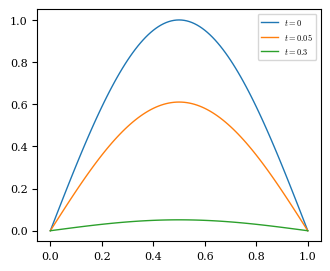

In [2]:
set_plot_params()

x10 = np.linspace(0, 1, 11)
x100 = np.linspace(0,1,101)
x1000 = np.linspace(0,1,1001)

ts_plot = [0, 0.05, 0.3]

x100_grid, t_grid = np.meshgrid(x100, ts_plot)
x10_grid, t_grid10 = np.meshgrid(x10, ts_plot)

points = np.vstack([x100, t_grid[0]])
a_sol_init = analytic_sol(points)


points = np.vstack([x100, t_grid[1]])
a_sol_t1 = analytic_sol(points)

points = np.vstack([x100, t_grid[2]])
a_sol_t2 = analytic_sol(points)

a_sols = np.append(a_sol_t1, a_sol_t2)


points = np.vstack([x10, t_grid10[1]])
a_sol10_t1 = analytic_sol(points)

points = np.vstack([x10, t_grid10[2]])
a_sol10_t2 = analytic_sol(points)


plt.plot(x100, a_sol_init, label = r"$t=0$")

plt.plot(x100, a_sol_t1, label = r"$t=0.05$")

plt.plot(x100, a_sol_t2, label = r"$t=0.3$")

plt.legend()
plt.show()

#### Comparing Point Sampling for Neural Network

In [3]:
its = 1

act_func = "silu"
nodes = 60
num_layers = 4
reg = None
reg_param = 0
learning_rate = 0.01

ts1_100 = np.ones_like(x100)*ts_plot[1]
ts2_100 = np.ones_like(x100)*ts_plot[2]

pred_t1 = np.vstack([x100, ts1_100]).T
pred_t2 = np.vstack([x100, ts2_100]).T

pred_points = np.vstack([pred_t1, pred_t2])
print(np.shape(pred_points))
print(pred_points[:3])

mat_mse_sampling = np.zeros((4,4))

(202, 2)
[[0.   0.05]
 [0.01 0.05]
 [0.02 0.05]]


#### Just points of interest

In [4]:
keras.utils.set_random_seed(2025)
for it in range(its):
    for i in range(4):
        x_train = np.linspace(0,1, int(10**(i+1)/2))
        
        t1_train = np.ones_like(x_train)*ts_plot[2]
        points_t1 = np.vstack([x_train,t1_train]).T
        
        t2_train = np.ones_like(x_train)*ts_plot[2]
        points_t2 = np.vstack([x_train,t2_train]).T
        
        train_points = np.vstack([points_t1,points_t2])
        
        print(np.shape(train_points))
        
        NN = HeatEqNN(num_layers, nodes, act_func, regularizer=reg,
                      reg_param=reg_param, learning_rate = learning_rate)
        NN.train(train_points, epochs=1000)
        pred = NN.predict(pred_points)
        mat_mse_sampling[0,i] = mse(pred, a_sols)
print(mat_mse_sampling[0,:])

(10, 2)


2025-12-18 16:15:24.341099: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(100, 2)
(1000, 2)
(10000, 2)
[0.03334165 0.02945003 0.03022155 0.02966059]


#### Grid

In [5]:
keras.utils.set_random_seed(2025)

grid_size = [(4,3), (10,10), (32,32), (100,100)]

for it in range(its):
    for i in range(4):
        x_n, t_n = grid_size[i]
        x_train = np.linspace(0,1, x_n)
        t_train = np.linspace(0,0.3, t_n)
        
        xs, ts = np.meshgrid(x_train, t_train)
        
        train_points = np.vstack([xs.ravel(), ts.ravel()]).T
        print(np.shape(train_points))
        
        NN = HeatEqNN(num_layers, nodes, act_func, regularizer=reg,
                      reg_param=reg_param, learning_rate = learning_rate)
        NN.train(train_points, epochs=1000)
        pred = NN.predict(pred_points)
        mat_mse_sampling[1,i] = mse(pred, a_sols)
print(mat_mse_sampling[1,:])

(12, 2)
(100, 2)
(1024, 2)
(10000, 2)
[9.59826144e-05 3.60510932e-07 1.36365234e-07 2.25320729e-07]


#### Uniformly Distributed

In [6]:
keras.utils.set_random_seed(2025)

for it in range(its):
    for i in range(4):
        x_train = np.random.uniform(0,1, 10**(i+1))
        t_train = np.random.uniform(0,0.3, 10**(i+1))
        
        train_points = np.vstack([x_train, t_train]).T
        print(np.shape(train_points))
        
        NN = HeatEqNN(num_layers, nodes, act_func, regularizer=reg,
                      reg_param=reg_param, learning_rate = learning_rate)
        NN.train(train_points, epochs=1000)
        pred = NN.predict(pred_points)
        mat_mse_sampling[2,i] = mse(pred, a_sols)
print(mat_mse_sampling[2,:])

(10, 2)
(100, 2)
(1000, 2)
(10000, 2)
[3.69281921e-04 3.23977770e-05 3.11161003e-07 2.13099953e-07]


#### Normally Distributed

In [7]:
keras.utils.set_random_seed(2025)

for it in range(its):
    for i in range(4):
        x_train = np.random.normal(0.5,0.5/3, 10**(i+1))
        t_train = np.random.normal(0.15,0.15/3, 10**(i+1))
        
        train_points = np.vstack([x_train, t_train]).T
        print(np.shape(train_points))
        
        NN = HeatEqNN(num_layers, nodes, act_func, regularizer=reg,
                      reg_param=reg_param, learning_rate = learning_rate)
        NN.train(train_points, epochs=1000)
        pred = NN.predict(pred_points)
        mat_mse_sampling[3,i] = mse(pred, a_sols)
print(mat_mse_sampling[3,:])

(10, 2)
(100, 2)
(1000, 2)
(10000, 2)
[1.69612504e-02 2.18781432e-04 2.17796525e-06 1.02184844e-06]


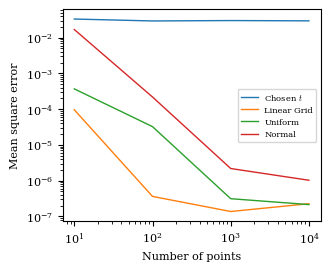

In [9]:
set_plot_params()

sampling = [r"Chosen $t$", "Linear Grid", "Uniform", "Normal"]
num_points = [10, 100, 1000, 10000]

for i in range(4):
    plt.loglog(num_points, mat_mse_sampling[i,:], label = sampling[i])

plt.xlabel("Number of points")
plt.ylabel("Mean square error")
plt.legend()
plt.savefig("../fig/point_sampling.pdf", bbox_inches="tight")
plt.show()
plt.close()